# Twitter Sentiment Analysis for Tweets directed to airlines

## Imports

In [1304]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split




## First cleaning of the data

In [1305]:
raw_data = pd.read_csv('./data/raw_data.csv')
raw_data.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [1306]:
data=raw_data[['airline_sentiment','text']]     
data.head()


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [1307]:
data.describe()

,airline_sentiment,text
count,14640,14640
unique,3,14427
top,negative,@united thanks
freq,9178,6


no null-values
3 sentiments (positive, neutral, negative)
some tweets appear more than once

In [1308]:
data = data.drop_duplicates(subset='text', keep="first")
data.describe()


,airline_sentiment,text
count,14427,14427
unique,3,14427
top,negative,@VirginAmerica What @dhepburn said.
freq,9080,1


## Data Understanding

Wie viele pos / neg / neut?

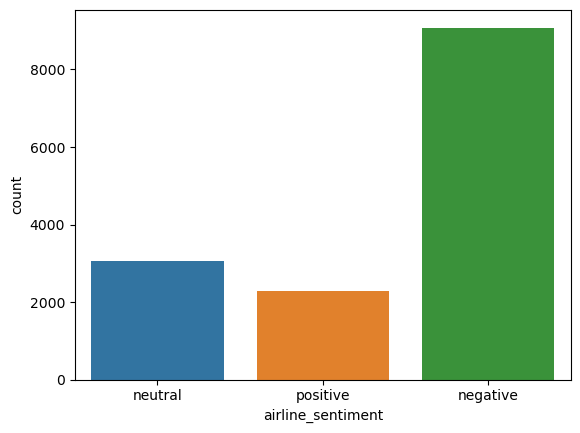

In [1309]:
sns.countplot(x='airline_sentiment', data=data)
plt.show()



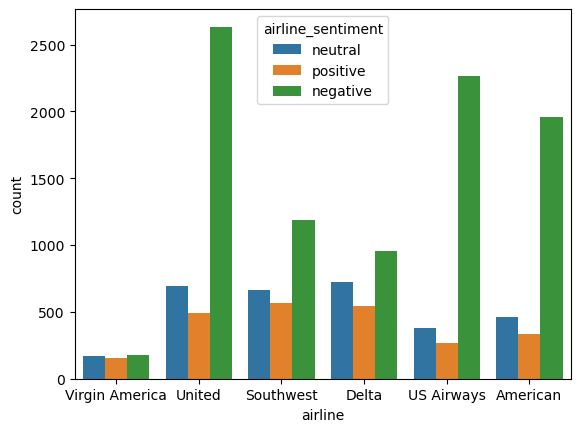

In [1310]:
sns.countplot(x='airline', hue='airline_sentiment', data=raw_data) # raw_data is used to get the airlines back, therefore the duplicates are back as well but will be ignored for the plots as there are only around 200 
plt.show()


### Aufteilung in important und unimportant

Da mehr negative Tweets vorhanden sind, als positive und neutrale besteht die Gefahr, dass im Modell ein Bias entwickelt wird.
1. um das zu verhindern und 
2. da in der Praxis lediglich eine Klassifizierung in wichtig (important) und unwichtig (unimportant) benötigt wird

werden die beiden Labels positiv und neutral als ein gemeinsames Label zusammengefasst.

In [1311]:
data['airline_sentiment'] = data['airline_sentiment'].replace(['negative', 'neutral', 'positive'], ['important', 'unimportant', 'unimportant'])

data.head()

,airline_sentiment,text
0,unimportant,@VirginAmerica What @dhepburn said.
1,unimportant,@VirginAmerica plus you've added commercials t...
2,unimportant,@VirginAmerica I didn't today... Must mean I n...
3,important,@VirginAmerica it's really aggressive to blast...
4,important,@VirginAmerica and it's a really big bad thing...


In [1312]:
data.describe()

,airline_sentiment,text
count,14427,14427
unique,2,14427
top,important,@VirginAmerica What @dhepburn said.
freq,9080,1


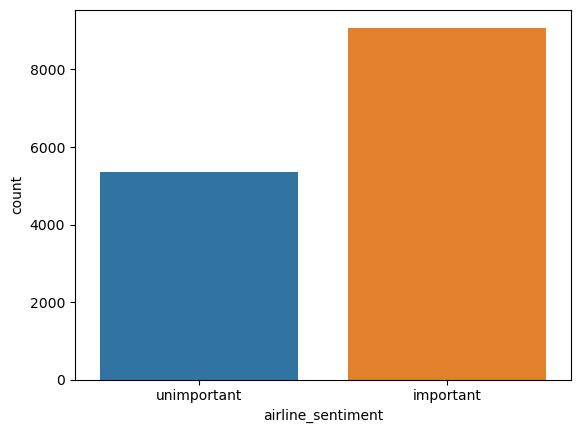

In [1313]:
sns.countplot(x='airline_sentiment', data=data)
plt.show()

In [1314]:
data['tokens'] = data['text'].apply(lambda x: x.split())

words = data['tokens'].apply(pd.Series).stack().unique()
num_words = len(words)
print('There are {} words in the text column.'.format(num_words))


There are 30105 words in the text column.


In [1315]:
cleaned_data = data[['airline_sentiment', 'text']]

def lower_case(input_text):
    return input_text.lower()
def remove_hashtags(input_text):
    return re.sub(r'#\S+', '', input_text)
def remove_mentions(input_text):
    return re.sub(r'@\S+', '', input_text)
def remove_links(input_text):
    return re.sub(r'http\S+', '', input_text)
def clean_texts(input_text):
    return re.sub('[^a-z ]+', '', input_text)

cleaned_data['text'] = cleaned_data['text'].apply(lower_case)
cleaned_data['text'] = cleaned_data['text'].apply(remove_hashtags)
cleaned_data['text'] = cleaned_data['text'].apply(remove_mentions)
cleaned_data['text'] = cleaned_data['text'].apply(remove_links)
cleaned_data['text'] = cleaned_data['text'].apply(clean_texts)
cleaned_data.head()

/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/3589125665.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['text'] = cleaned_data['text'].apply(lower_case)
/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/3589125665.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['text'] = cleaned_data['text'].apply(remove_hashtags)
/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/3589125665.py:16: SettingWithCopyWarning: 
A value is trying

,airline_sentiment,text
0,unimportant,what said
1,unimportant,plus youve added commercials to the experienc...
2,unimportant,i didnt today must mean i need to take anothe...
3,important,its really aggressive to blast obnoxious ente...
4,important,and its a really big bad thing about it


## Data Preparation for NLP

In [1316]:
#not used yet, only for visualsation of data preparation effects
cleaned_data['tokens'] = cleaned_data['text'].apply(lambda x: x.split())

words_cleaned = cleaned_data['tokens'].apply(pd.Series).stack().unique()
num_words_cleaned = len(words_cleaned)
print('There are {} words in the text column.'.format(num_words_cleaned))

There are 11226 words in the text column.


In [1317]:
cleaned_data.to_csv('./data/cleaned_data.csv', index=False)

### Stop Word Removal

In [1318]:
data_swr = cleaned_data[['airline_sentiment', 'text']]

In [1319]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

{'very', 'out', 'have', 'them', 'between', "isn't", 'up', 'd', "weren't", 'a', 'an', 'his', 'after', "shan't", 'until', 'under', 'were', 'her', 'didn', 'yourselves', 'why', "aren't", 'does', 'too', 'but', 'those', 'then', 'whom', 'shan', 'having', 'haven', 'other', 'if', 'at', 'should', 'now', 'when', "didn't", 'in', 'yourself', "don't", 'll', 'being', 'on', "mustn't", "hasn't", "hadn't", 'him', 'not', 'our', 'm', 'was', 't', 'its', 'where', 'few', "wasn't", 'both', 'what', 're', 'wasn', 'my', 'it', 'further', 'once', 'wouldn', 'off', 'had', 'your', 'we', 'own', 'am', 'some', 'are', 'that', 'of', "shouldn't", 'because', 'mustn', 'how', 'their', 'each', 'he', 'by', 'has', 'with', "that'll", "needn't", 'itself', 'here', "haven't", 'there', 'needn', 'doesn', 'ma', 'be', "she's", 'herself', 'mightn', 'they', 've', 'isn', "you've", 'do', 'as', "you'd", 'so', "you're", 'while', 'doing', 'more', 'hers', "should've", 'over', 'the', 'during', "wouldn't", 'myself', 'will', 'did', 'about', 'o', '

[nltk_data] Downloading package stopwords to /Users/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1320]:
def remove_stopwords(input_text):
    return ' '.join([word for word in input_text.split() if word not in stop_words])
data_swr['text'] = data_swr['text'].apply(remove_stopwords) 
data_swr.head()

/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/4206056295.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_swr['text'] = data_swr['text'].apply(remove_stopwords)


,airline_sentiment,text
0,unimportant,said
1,unimportant,plus youve added commercials experience tacky
2,unimportant,didnt today must mean need take another trip
3,important,really aggressive blast obnoxious entertainmen...
4,important,really big bad thing


In [1321]:
#not used yet, only for visualsation of data preparation effects
data_swr['tokens'] = data_swr['text'].apply(lambda x: x.split())

words_after_swr = data_swr['tokens'].apply(pd.Series).stack().unique()
num_words_after_swr = len(words_after_swr)
print('There are {} words in the text column after stop word removal.'.format(num_words_after_swr))

/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/3264614295.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  words_after_swr = data_swr['tokens'].apply(pd.Series).stack().unique()


There are 11094 words in the text column after stop word removal.


In [1322]:
data_swr.to_csv('./data/data_swr.csv', index=False)

### Lemmatization

In [1323]:
data_lem = data_swr[['airline_sentiment', 'text']]

In [1324]:
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
def lemmatize_text(input_text):
    return ' '.join([lemmatizer.lemmatize(word) for word in input_text.split()])
data_lem['text'] =data_lem['text'].apply(lemmatize_text)
data_lem.head()


[nltk_data] Downloading package wordnet to /Users/simon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/simon/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/253529818.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_lem['text'] =data_lem['text'].apply(lemmatize_text)


,airline_sentiment,text
0,unimportant,said
1,unimportant,plus youve added commercial experience tacky
2,unimportant,didnt today must mean need take another trip
3,important,really aggressive blast obnoxious entertainmen...
4,important,really big bad thing


In [1325]:
#not used yet, only for visualsation of data preparation effects
data_lem['tokens'] = data_lem['text'].apply(lambda x: x.split())

words_after_lem = data_lem['tokens'].apply(pd.Series).stack().unique()
num_words_after_lem = len(words_after_lem)
print('There are {} words in the text column after lemmatization.'.format(num_words_after_lem))

/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/2560290298.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  words_after_lem = data_lem['tokens'].apply(pd.Series).stack().unique()


There are 10177 words in the text column after lemmatization.


In [1326]:
data_lem.to_csv('./data/data_lem.csv', index=False)

### Stemming

In [1327]:
data_stem = data_swr[['airline_sentiment', 'text']]

In [1328]:
stemmer = PorterStemmer()
def stem_text(input_text):
    return ' '.join([stemmer.stem(word) for word in input_text.split()])
data_stem['text'] = data_stem['text'].apply(stem_text)
data_stem.head()

/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/491637868.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_stem['text'] = data_stem['text'].apply(stem_text)


,airline_sentiment,text
0,unimportant,said
1,unimportant,plu youv ad commerci experi tacki
2,unimportant,didnt today must mean need take anoth trip
3,important,realli aggress blast obnoxi entertain guest fa...
4,important,realli big bad thing


In [1329]:
#not used yet, only for visualsation of data preparation effects
data_stem['tokens'] = data_stem['text'].apply(lambda x: x.split())

words_after_stem = data_stem['tokens'].apply(pd.Series).stack().unique()
num_words_after_stem = len(words_after_stem)
print('There are {} words in the text column after stemming.'.format(num_words_after_stem))

/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/4164810043.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  words_after_stem = data_stem['tokens'].apply(pd.Series).stack().unique()


There are 8440 words in the text column after stemming.


In [1330]:
data_stem.to_csv('./data/data_stem.csv', index=False)

### Plot to showcase the effectiveness of Data Preparation

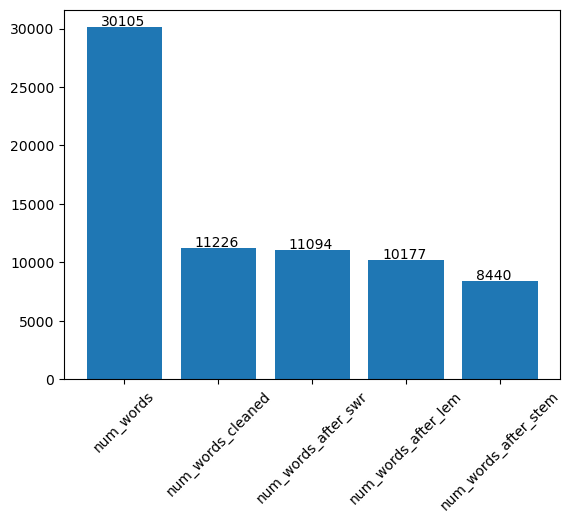

In [1331]:
num_words_list = [num_words, num_words_cleaned, num_words_after_swr, num_words_after_lem, num_words_after_stem]
labels = ['num_words','num_words_cleaned', 'num_words_after_swr', 'num_words_after_lem', 'num_words_after_stem']
plt.bar(labels, num_words_list)
plt.xticks(rotation=45)

for i in range(len(num_words_list)):
    plt.text(x=i-0.25 , y=num_words_list[i]+100, s=num_words_list[i], size=10)
plt.show()



## Different Models 

In [1332]:
results = pd.DataFrame(columns=['model', 'data_prep', 'vectorizer', 'accuracy', 'f1_score', 'precision', 'recall'])

### Lemmatization

##### Train Test Split

In [1333]:
X_train, X_test, y_train, y_test = train_test_split(data_lem['text'], data_lem['airline_sentiment'], test_size=0.2, random_state=42)

#### Feature Extraction

##### TF-IDF

In [1334]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

##### Count Vectorizer

In [1335]:
vectorizer = CountVectorizer()
X_train_countvec = vectorizer.fit_transform(X_train)
X_test_countvec = vectorizer.transform(X_test)

##### Naive Bayes

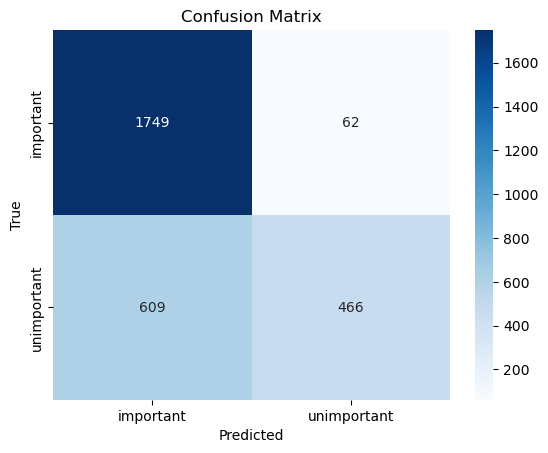

Naive Bayes - Lemmatization - TF-IDF: 
 Accuracy: 0.7674982674982676 
 F1-Score: 0.710229994222574 
 Precision: 0.8121530187369882 
 Recall: 0.6996265714689303


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/293426499.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'Naive Bayes', 'data_prep': 'Lemmatization', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1336]:
nb_model_tfidf = MultinomialNB()
nb_model_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = nb_model_tfidf.predict(X_test_tfidf)

train_accuracy = nb_model_tfidf.score(X_train_tfidf, y_train)

accuracy = accuracy_score(y_test, y_pred_tfidf)
f1 = f1_score(y_test, y_pred_tfidf, average='macro')
precision = precision_score(y_test, y_pred_tfidf, average='macro')
recall = recall_score(y_test, y_pred_tfidf, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_tfidf, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'Naive Bayes', 'data_prep': 'Lemmatization', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"Naive Bayes - Lemmatization - TF-IDF: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

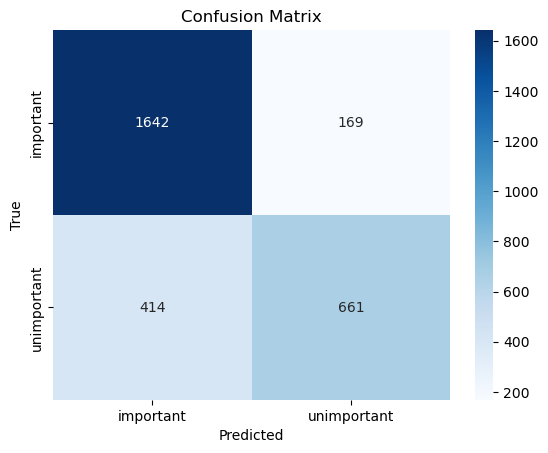

Naive Bayes - Lemmatization - CountVectorizer: 
 Accuracy: 0.797990297990298 
 F1-Score: 0.7716001946614702 
 Precision: 0.7975118372321973 
 Recall: 0.7607825562133217


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/1768884348.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'Naive Bayes', 'data_prep': 'Lemmatization', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1337]:
nb_model_countvec = MultinomialNB()
nb_model_countvec.fit(X_train_countvec, y_train)

y_pred_countvec = nb_model_countvec.predict(X_test_countvec)

train_accuracy = nb_model_countvec.score(X_train_countvec, y_train)

accuracy = accuracy_score(y_test, y_pred_countvec)
f1 = f1_score(y_test, y_pred_countvec, average='macro')
precision = precision_score(y_test, y_pred_countvec, average='macro')
recall = recall_score(y_test, y_pred_countvec, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_countvec, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'Naive Bayes', 'data_prep': 'Lemmatization', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"Naive Bayes - Lemmatization - CountVectorizer: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

##### Logistic Regression

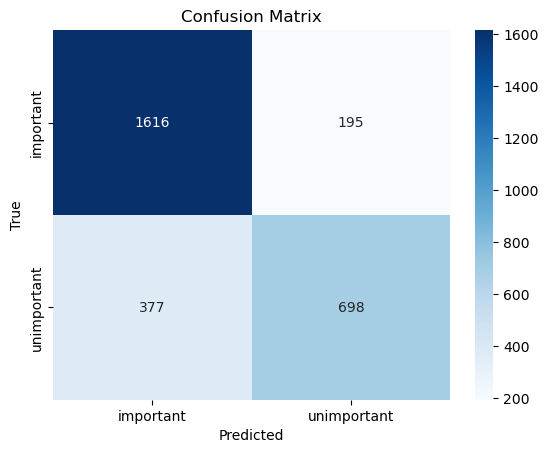

Softmax Regression - Lemmatization - TF-IDF: 
 Accuracy: 0.8018018018018018 
 F1-Score: 0.7794907799235721 
 Precision: 0.7962364355872654 
 Recall: 0.770813504038627


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/1326302266.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'Logistic Regression', 'data_prep': 'Lemmatization', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1338]:
logreg_tfidf = LogisticRegression()
logreg_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = logreg_tfidf.predict(X_test_tfidf)

train_accuracy = logreg_tfidf.score(X_train_tfidf, y_train)

accuracy = accuracy_score(y_test, y_pred_tfidf)
f1 = f1_score(y_test, y_pred_tfidf, average='macro')
precision = precision_score(y_test, y_pred_tfidf, average='macro')
recall = recall_score(y_test, y_pred_tfidf, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_tfidf, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'Logistic Regression', 'data_prep': 'Lemmatization', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"Softmax Regression - Lemmatization - TF-IDF: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

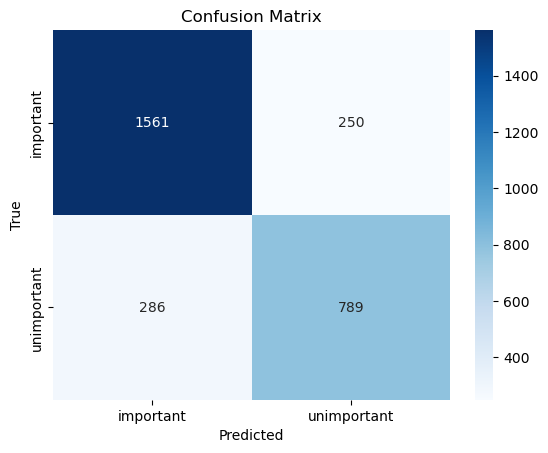

Softmax Regression - Lemmatization - CountVectorizer: 
 Accuracy: 0.8142758142758143 
 F1-Score: 0.7999620329051604 
 Precision: 0.80226916368817 
 Recall: 0.7979541047603149


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/1695832958.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'Logistic Regression', 'data_prep': 'Lemmatization', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1339]:
logreg_countvec = LogisticRegression()
logreg_countvec.fit(X_train_countvec, y_train)

y_pred_countvec = logreg_countvec.predict(X_test_countvec)

train_accuracy = logreg_countvec.score(X_train_countvec, y_train)

accuracy = accuracy_score(y_test, y_pred_countvec)
f1 = f1_score(y_test, y_pred_countvec, average='macro')
precision = precision_score(y_test, y_pred_countvec, average='macro')
recall = recall_score(y_test, y_pred_countvec, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_countvec, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'Logistic Regression', 'data_prep': 'Lemmatization', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"Softmax Regression - Lemmatization - CountVectorizer: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")


##### Support Vector Machine

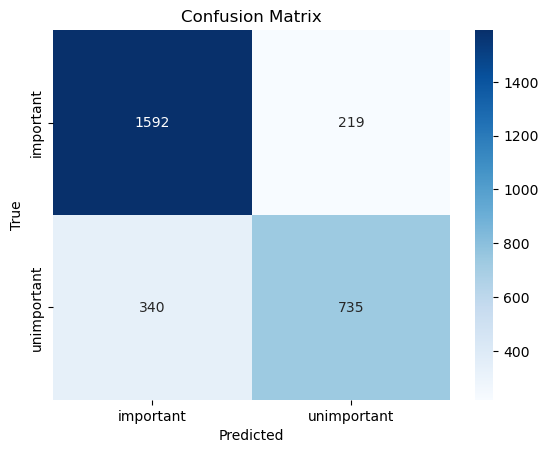

SVM - Lemmatization - TF-IDF: 
 Accuracy: 0.8063063063063063 
 F1-Score: 0.787574690103307 
 Precision: 0.7972284073596625 
 Recall: 0.7813966329793381


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/1110594748.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'SVM', 'data_prep': 'Lemmatization', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1340]:
svm_tfidf = SVC(kernel='linear', C=1.0, decision_function_shape='ovr')
svm_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = svm_tfidf.predict(X_test_tfidf)

train_accuracy = svm_tfidf.score(X_train_tfidf, y_train)

accuracy = accuracy_score(y_test, y_pred_tfidf)
f1 = f1_score(y_test, y_pred_tfidf, average='macro')
precision = precision_score(y_test, y_pred_tfidf, average='macro')
recall = recall_score(y_test, y_pred_tfidf, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_tfidf, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'SVM', 'data_prep': 'Lemmatization', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"SVM - Lemmatization - TF-IDF: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

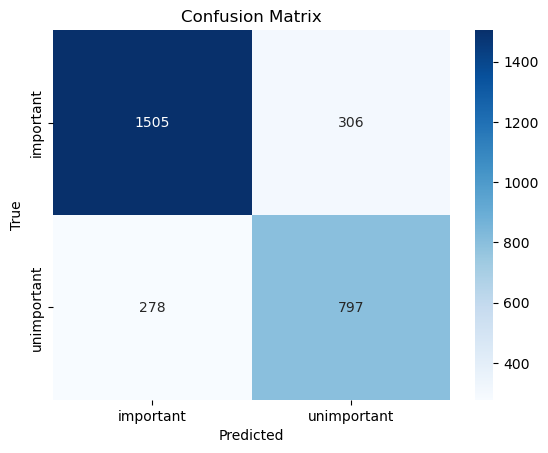

SVM - Lemmatization - CountVectorizer: 
 Accuracy: 0.7976437976437977 
 F1-Score: 0.78468552576915 
 Precision: 0.7833289010901284 
 Recall: 0.7862139637615091


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/2874611548.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'SVM', 'data_prep': 'Lemmatization', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1341]:
svm_countvec = SVC(kernel='linear', C=1.0, decision_function_shape='ovr')
svm_countvec.fit(X_train_countvec, y_train)

y_pred_countvec = svm_countvec.predict(X_test_countvec)

train_accuracy = svm_countvec.score(X_train_countvec, y_train)

accuracy = accuracy_score(y_test, y_pred_countvec)
f1 = f1_score(y_test, y_pred_countvec, average='macro')
precision = precision_score(y_test, y_pred_countvec, average='macro')
recall = recall_score(y_test, y_pred_countvec, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_countvec, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'SVM', 'data_prep': 'Lemmatization', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"SVM - Lemmatization - CountVectorizer: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

##### Decision Tree

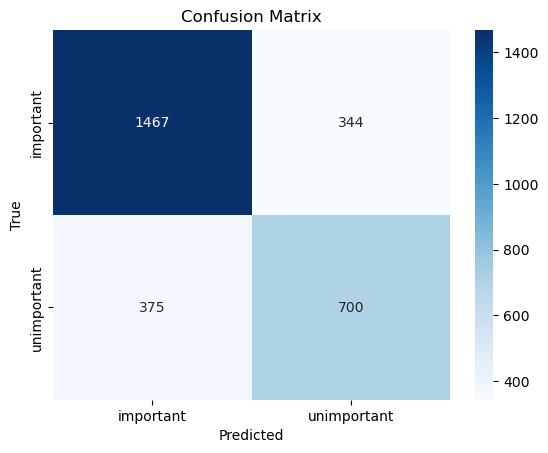

Decision Tree - Lemmatization - TF-IDF: 
 Accuracy: 0.7508662508662509 
 F1-Score: 0.7319322382309522 
 Precision: 0.7334575112009685 
 Recall: 0.7306062434990305


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/3862216708.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'Decision Tree', 'data_prep': 'Lemmatization', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1342]:
dt_tfidf = DecisionTreeClassifier()
dt_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = dt_tfidf.predict(X_test_tfidf)

train_accuracy = dt_tfidf.score(X_train_tfidf, y_train)

accuracy = accuracy_score(y_test, y_pred_tfidf)
f1 = f1_score(y_test, y_pred_tfidf, average='macro')
precision = precision_score(y_test, y_pred_tfidf, average='macro')
recall = recall_score(y_test, y_pred_tfidf, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_tfidf, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'Decision Tree', 'data_prep': 'Lemmatization', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"Decision Tree - Lemmatization - TF-IDF: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

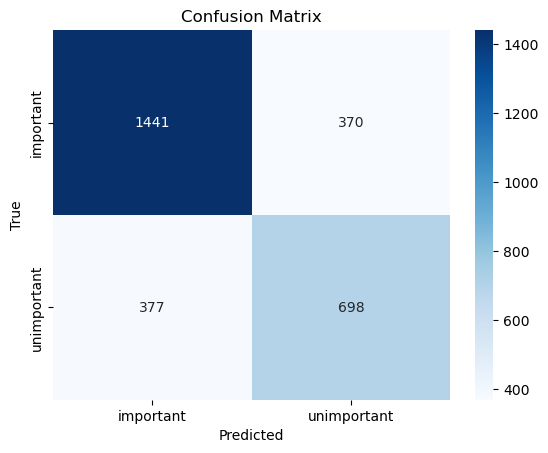

Decision Tree - Lemmatization - CountVectorizer: 
 Accuracy: 0.7411642411642412 
 F1-Score: 0.7227907043728086 
 Precision: 0.7230936576803748 
 Recall: 0.7224976564406149


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/946990368.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'Decision Tree', 'data_prep': 'Lemmatization', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1343]:
dt_countvec = DecisionTreeClassifier()
dt_countvec.fit(X_train_countvec, y_train)

y_pred_countvec = dt_countvec.predict(X_test_countvec)

train_accuracy = dt_countvec.score(X_train_countvec, y_train)

accuracy = accuracy_score(y_test, y_pred_countvec)
f1 = f1_score(y_test, y_pred_countvec, average='macro')
precision = precision_score(y_test, y_pred_countvec, average='macro')
recall = recall_score(y_test, y_pred_countvec, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_countvec, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'Decision Tree', 'data_prep': 'Lemmatization', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"Decision Tree - Lemmatization - CountVectorizer: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

##### Random Forest

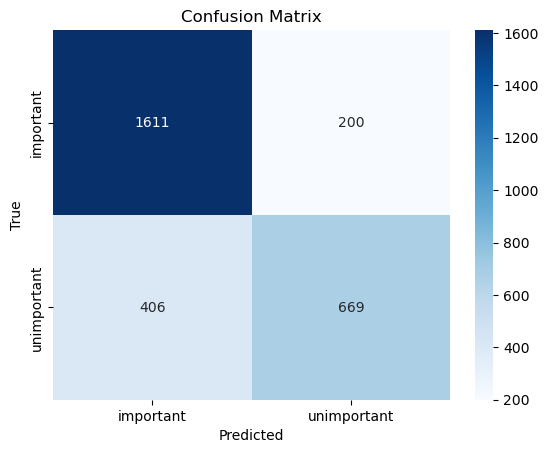

Random Forest - Lemmatization - TF-IDF: 
 Accuracy: 0.7900207900207901 
 F1-Score: 0.7649821974534619 
 Precision: 0.7842806798142143 
 Recall: 0.7559446791570892


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/2378884685.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'Random Forest', 'data_prep': 'Lemmatization', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1344]:
rf_tfidf = RandomForestClassifier()
rf_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = rf_tfidf.predict(X_test_tfidf)

train_accuracy = rf_tfidf.score(X_train_tfidf, y_train)

accuracy = accuracy_score(y_test, y_pred_tfidf)
f1 = f1_score(y_test, y_pred_tfidf, average='macro')
precision = precision_score(y_test, y_pred_tfidf, average='macro')
recall = recall_score(y_test, y_pred_tfidf, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_tfidf, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'Random Forest', 'data_prep': 'Lemmatization', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"Random Forest - Lemmatization - TF-IDF: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

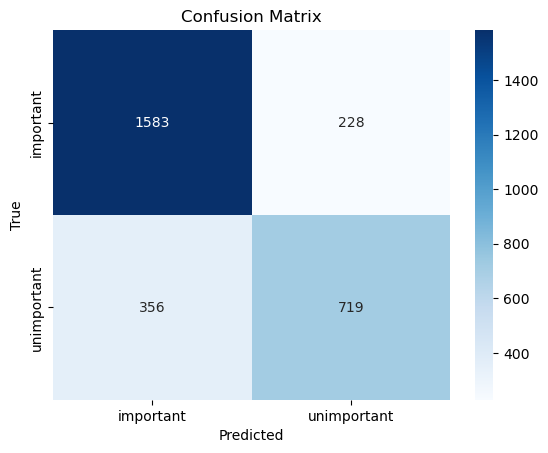

Random Forest - Lemmatization - CountVectorizer: 
 Accuracy: 0.7976437976437977 
 F1-Score: 0.7777218595450051 
 Precision: 0.7878199553106822 
 Recall: 0.7714699574948956


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/1694422822.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'Random Forest', 'data_prep': 'Lemmatization', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1345]:
rf_countvec = RandomForestClassifier()
rf_countvec.fit(X_train_countvec, y_train)

y_pred_countvec = rf_countvec.predict(X_test_countvec)

train_accuracy = rf_countvec.score(X_train_countvec, y_train)

accuracy = accuracy_score(y_test, y_pred_countvec)
f1 = f1_score(y_test, y_pred_countvec, average='macro')
precision = precision_score(y_test, y_pred_countvec, average='macro')
recall = recall_score(y_test, y_pred_countvec, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_countvec, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'Random Forest', 'data_prep': 'Lemmatization', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"Random Forest - Lemmatization - CountVectorizer: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")


##### Neural Network

/Users/simon/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


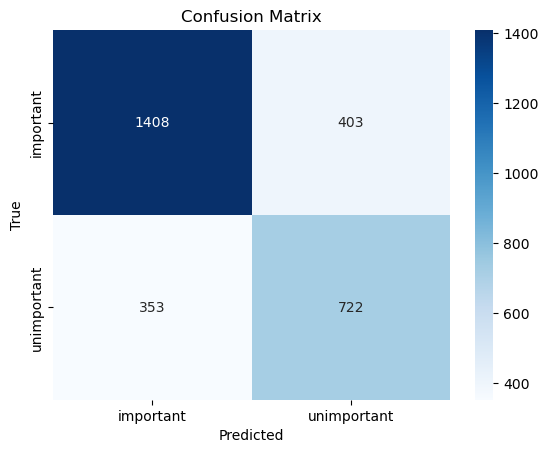

MLP - Lemmatization - TF-IDF: 
 Accuracy: 0.738045738045738 
 F1-Score: 0.7223587498727477 
 Precision: 0.7206617452205186 
 Recall: 0.7245494587340927


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/1450200961.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'MLP', 'data_prep': 'Lemmatization', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1346]:
mlp_tfidf = MLPClassifier(hidden_layer_sizes=(5,3))
mlp_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = mlp_tfidf.predict(X_test_tfidf)

train_accuracy = mlp_tfidf.score(X_train_tfidf, y_train)

accuracy = accuracy_score(y_test, y_pred_tfidf)
f1 = f1_score(y_test, y_pred_tfidf, average='macro')
precision = precision_score(y_test, y_pred_tfidf, average='macro')
recall = recall_score(y_test, y_pred_tfidf, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_tfidf, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'MLP', 'data_prep': 'Lemmatization', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"MLP - Lemmatization - TF-IDF: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

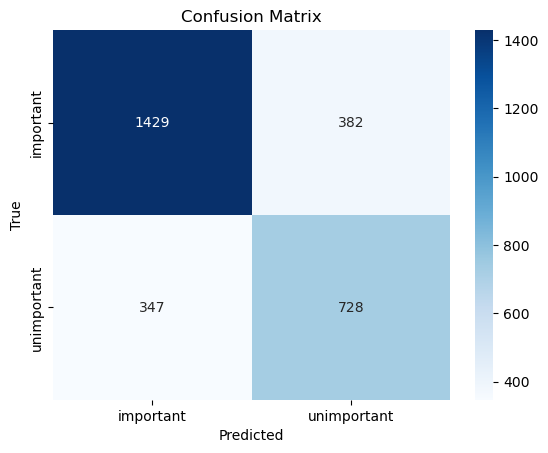

MLP - Lemmatization - CountVectorizer: 
 Accuracy: 0.7474012474012474 
 F1-Score: 0.7315638279344621 
 Precision: 0.7302364864864865 
 Recall: 0.7331380581202728


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/1170759091.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'MLP', 'data_prep': 'Lemmatization', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1347]:
mpl_countvec = MLPClassifier(hidden_layer_sizes=(5,3))
mpl_countvec.fit(X_train_countvec, y_train)

y_pred_countvec = mpl_countvec.predict(X_test_countvec)

train_accuracy = mpl_countvec.score(X_train_countvec, y_train)

accuracy = accuracy_score(y_test, y_pred_countvec)
f1 = f1_score(y_test, y_pred_countvec, average='macro')
precision = precision_score(y_test, y_pred_countvec, average='macro')
recall = recall_score(y_test, y_pred_countvec, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_countvec, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'MLP', 'data_prep': 'Lemmatization', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"MLP - Lemmatization - CountVectorizer: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

### Stemming

##### Train Test Split

In [1348]:
X_train, X_test, y_train, y_test = train_test_split(data_stem['text'], data_stem['airline_sentiment'], test_size=0.2, random_state=42)

#### Feature Extraction

##### TF-IDF

In [1349]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

##### Count Vectorizer

In [1350]:
vectorizer = CountVectorizer()
X_train_countvec = vectorizer.fit_transform(X_train)
X_test_countvec = vectorizer.transform(X_test)

#### Modelle

##### Naive Bayes

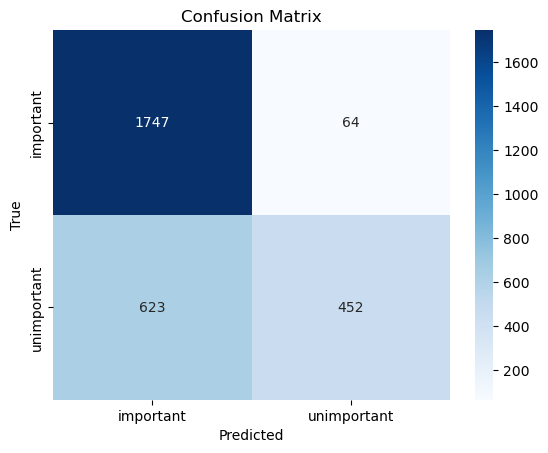

Naive Bayes - Stemming - TF-IDF: 
 Accuracy: 0.761954261954262 
 F1-Score: 0.7019406729223565 
 Precision: 0.8065498969679128 
 Recall: 0.6925627624465476


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/2770012450.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'Naive Bayes', 'data_prep': 'Stemming', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1351]:
nb_model_tfidf = MultinomialNB()
nb_model_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = nb_model_tfidf.predict(X_test_tfidf)

train_accuracy = nb_model_tfidf.score(X_train_tfidf, y_train)

accuracy = accuracy_score(y_test, y_pred_tfidf)
f1 = f1_score(y_test, y_pred_tfidf, average='macro')
precision = precision_score(y_test, y_pred_tfidf, average='macro')
recall = recall_score(y_test, y_pred_tfidf, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_tfidf, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'Naive Bayes', 'data_prep': 'Stemming', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"Naive Bayes - Stemming - TF-IDF: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

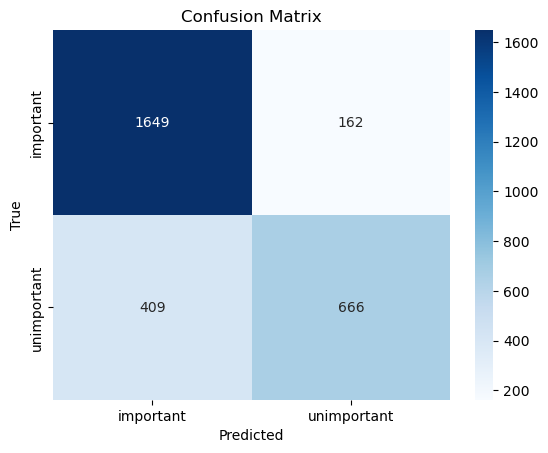

Naive Bayes - Stemming - CountVectorizer: 
 Accuracy: 0.8021483021483021 
 F1-Score: 0.7761820482602391 
 Precision: 0.8028055942874044 
 Recall: 0.7650407715125911


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/3387307148.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'Naive Bayes', 'data_prep': 'Stemming', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1352]:
nb_model_countvec = MultinomialNB()
nb_model_countvec.fit(X_train_countvec, y_train)

y_pred_countvec = nb_model_countvec.predict(X_test_countvec)

train_accuracy = nb_model_countvec.score(X_train_countvec, y_train)

accuracy = accuracy_score(y_test, y_pred_countvec)
f1 = f1_score(y_test, y_pred_countvec, average='macro')
precision = precision_score(y_test, y_pred_countvec, average='macro')
recall = recall_score(y_test, y_pred_countvec, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_countvec, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'Naive Bayes', 'data_prep': 'Stemming', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"Naive Bayes - Stemming - CountVectorizer: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

##### Logistic Regression

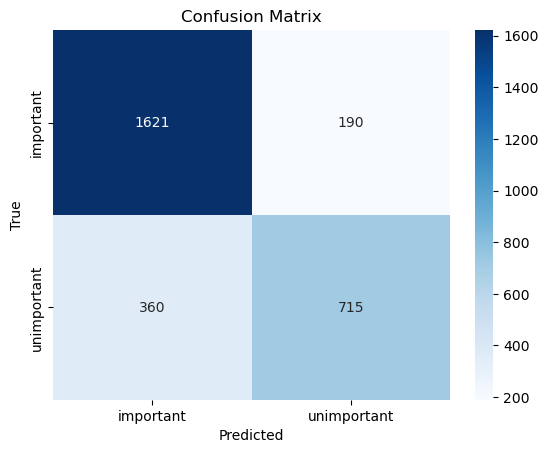

Softmax Regression - Stemming - TF-IDF: 
 Accuracy: 0.8094248094248094 
 F1-Score: 0.7885900140646978 
 Precision: 0.8041644239055559 
 Recall: 0.7801009335713277


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/1974927267.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'Logistic Regression', 'data_prep': 'Stemming', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1353]:
logreg_tfidf = LogisticRegression()
logreg_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = logreg_tfidf.predict(X_test_tfidf)

train_accuracy = logreg_tfidf.score(X_train_tfidf, y_train)

accuracy = accuracy_score(y_test, y_pred_tfidf)
f1 = f1_score(y_test, y_pred_tfidf, average='macro')
precision = precision_score(y_test, y_pred_tfidf, average='macro')
recall = recall_score(y_test, y_pred_tfidf, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_tfidf, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'Logistic Regression', 'data_prep': 'Stemming', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"Softmax Regression - Stemming - TF-IDF: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

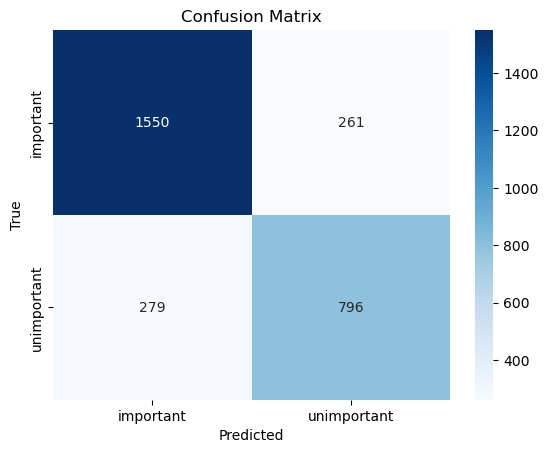

Softmax Regression - Stemming - CountVectorizer: 
 Accuracy: 0.8128898128898129 
 F1-Score: 0.7991825247922809 
 Precision: 0.8002661834741753 
 Recall: 0.798172922579071


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/3367952558.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'Logistic Regression', 'data_prep': 'Stemming', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1354]:
logreg_countvec = LogisticRegression()
logreg_countvec.fit(X_train_countvec, y_train)

y_pred_countvec = logreg_countvec.predict(X_test_countvec)

train_accuracy = logreg_countvec.score(X_train_countvec, y_train)

accuracy = accuracy_score(y_test, y_pred_countvec)
f1 = f1_score(y_test, y_pred_countvec, average='macro')
precision = precision_score(y_test, y_pred_countvec, average='macro')
recall = recall_score(y_test, y_pred_countvec, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_countvec, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'Logistic Regression', 'data_prep': 'Stemming', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"Softmax Regression - Stemming - CountVectorizer: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

##### Support Vector Machine

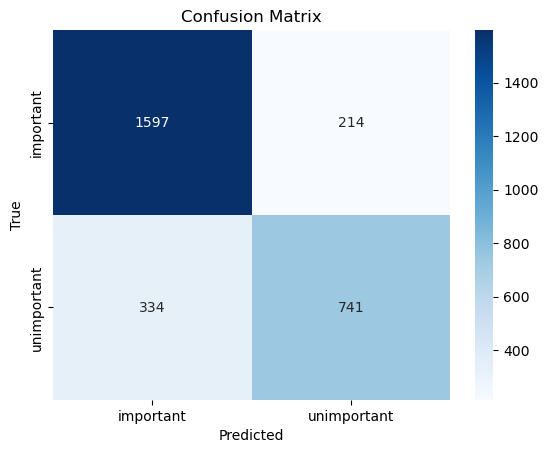

SVM - Stemming - TF-IDF: 
 Accuracy: 0.8101178101178101 
 F1-Score: 0.7918017550742076 
 Precision: 0.8014744279745459 
 Recall: 0.7855677834422714


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/329439752.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'SVM', 'data_prep': 'Stemming', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1355]:
svm_tfidf = SVC(kernel='linear', C=1.0, decision_function_shape='ovr')
svm_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = svm_tfidf.predict(X_test_tfidf)

train_accuracy = svm_tfidf.score(X_train_tfidf, y_train)

accuracy = accuracy_score(y_test, y_pred_tfidf)
f1 = f1_score(y_test, y_pred_tfidf, average='macro')
precision = precision_score(y_test, y_pred_tfidf, average='macro')
recall = recall_score(y_test, y_pred_tfidf, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_tfidf, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'SVM', 'data_prep': 'Stemming', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"SVM - Stemming - TF-IDF: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

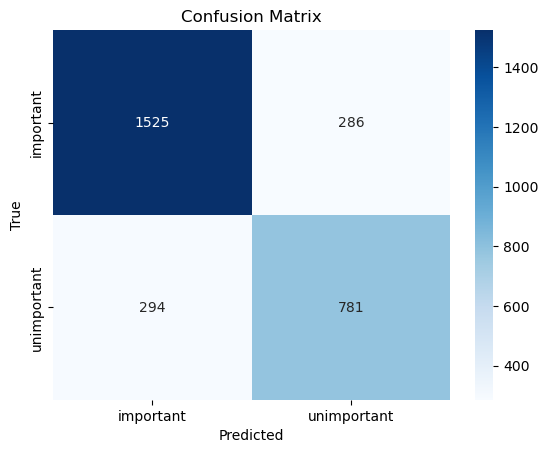

SVM - Stemming - CountVectorizer: 
 Accuracy: 0.799029799029799 
 F1-Score: 0.7847227045088008 
 Precision: 0.7851657475785381 
 Recall: 0.7842939144504514


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/3492794675.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'SVM', 'data_prep': 'Stemming', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1356]:
svm_countvec = SVC(kernel='linear', C=1.0, decision_function_shape='ovr')
svm_countvec.fit(X_train_countvec, y_train)

y_pred_countvec = svm_countvec.predict(X_test_countvec)

train_accuracy = svm_countvec.score(X_train_countvec, y_train)

accuracy = accuracy_score(y_test, y_pred_countvec)
f1 = f1_score(y_test, y_pred_countvec, average='macro')
precision = precision_score(y_test, y_pred_countvec, average='macro')
recall = recall_score(y_test, y_pred_countvec, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_countvec, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'SVM', 'data_prep': 'Stemming', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"SVM - Stemming - CountVectorizer: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

##### Decision Tree

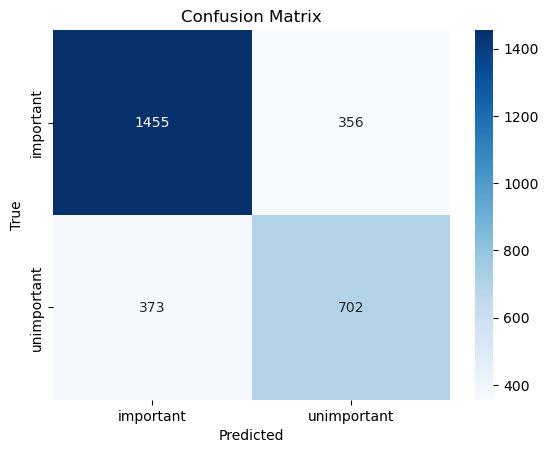

Decision Tree - Stemming - TF-IDF: 
 Accuracy: 0.7474012474012474 
 F1-Score: 0.7289490435889676 
 Precision: 0.7297339640045832 
 Recall: 0.728223389364735


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/3921962064.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'Decision Tree', 'data_prep': 'Stemming', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1357]:
dt_tfidf = DecisionTreeClassifier()
dt_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = dt_tfidf.predict(X_test_tfidf)

train_accuracy = dt_tfidf.score(X_train_tfidf, y_train)

accuracy = accuracy_score(y_test, y_pred_tfidf)
f1 = f1_score(y_test, y_pred_tfidf, average='macro')
precision = precision_score(y_test, y_pred_tfidf, average='macro')
recall = recall_score(y_test, y_pred_tfidf, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_tfidf, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'Decision Tree', 'data_prep': 'Stemming', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"Decision Tree - Stemming - TF-IDF: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

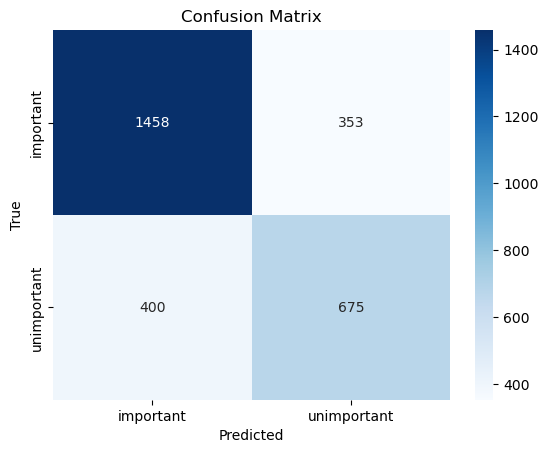

Decision Tree - Stemming - CountVectorizer: 
 Accuracy: 0.739085239085239 
 F1-Score: 0.7183535260339453 
 Precision: 0.7206647665160228 
 Recall: 0.71649352150296


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/2571029836.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'Decision Tree', 'data_prep': 'Stemming', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1358]:
dt_countvec = DecisionTreeClassifier()
dt_countvec.fit(X_train_countvec, y_train)

y_pred_countvec = dt_countvec.predict(X_test_countvec)

train_accuracy = dt_countvec.score(X_train_countvec, y_train)

accuracy = accuracy_score(y_test, y_pred_countvec)
f1 = f1_score(y_test, y_pred_countvec, average='macro')
precision = precision_score(y_test, y_pred_countvec, average='macro')
recall = recall_score(y_test, y_pred_countvec, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_countvec, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'Decision Tree', 'data_prep': 'Stemming', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"Decision Tree - Stemming - CountVectorizer: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")


##### Random Forest

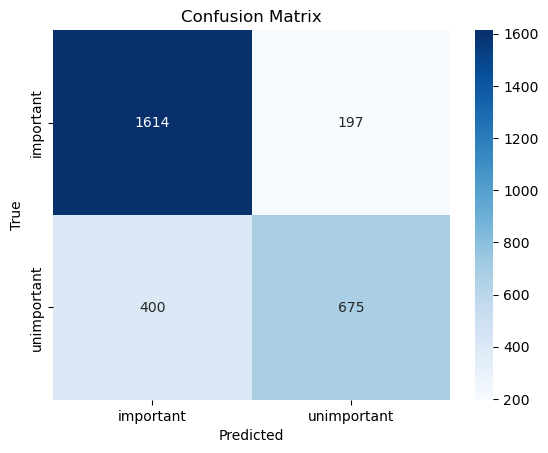

Random Forest - Stemming - TF-IDF: 
 Accuracy: 0.7931392931392931 
 F1-Score: 0.7686479954077163 
 Precision: 0.7877364184652388 
 Recall: 0.7595636485046164


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/4100387705.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'Random Forest', 'data_prep': 'Stemming', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1359]:
rf_tfidf = RandomForestClassifier()
rf_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = rf_tfidf.predict(X_test_tfidf)

train_accuracy = rf_tfidf.score(X_train_tfidf, y_train)

accuracy = accuracy_score(y_test, y_pred_tfidf)
f1 = f1_score(y_test, y_pred_tfidf, average='macro')
precision = precision_score(y_test, y_pred_tfidf, average='macro')
recall = recall_score(y_test, y_pred_tfidf, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_tfidf, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'Random Forest', 'data_prep': 'Stemming', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"Random Forest - Stemming - TF-IDF: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

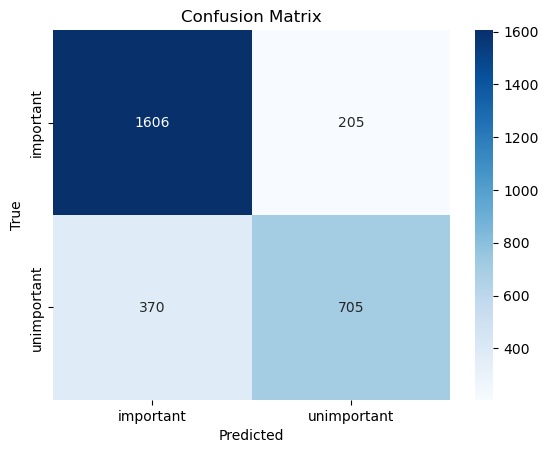

Random Forest - Stemming - CountVectorizer: 
 Accuracy: 0.8007623007623008 
 F1-Score: 0.7792461150735082 
 Precision: 0.7937391555812608 
 Recall: 0.7713084124150862


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/1999871427.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'Random Forest', 'data_prep': 'Stemming', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1360]:
rf_countvec = RandomForestClassifier()
rf_countvec.fit(X_train_countvec, y_train)

y_pred_countvec = rf_countvec.predict(X_test_countvec)

train_accuracy = rf_countvec.score(X_train_countvec, y_train)

accuracy = accuracy_score(y_test, y_pred_countvec)
f1 = f1_score(y_test, y_pred_countvec, average='macro')
precision = precision_score(y_test, y_pred_countvec, average='macro')
recall = recall_score(y_test, y_pred_countvec, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_countvec, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'Random Forest', 'data_prep': 'Stemming', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"Random Forest - Stemming - CountVectorizer: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

##### Neural Network

/Users/simon/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


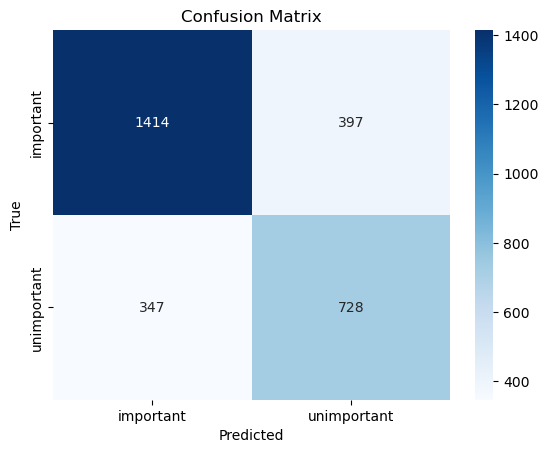

MLP - Stemming - TF-IDF: 
 Accuracy: 0.7422037422037422 
 F1-Score: 0.7267657538430214 
 Precision: 0.7250319893999622 
 Recall: 0.7289966997547288


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/1374425070.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'MLP', 'data_prep': 'Stemming', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1361]:
mlp_tfidf = MLPClassifier(hidden_layer_sizes=(5,3))
mlp_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = mlp_tfidf.predict(X_test_tfidf)

train_accuracy = mlp_tfidf.score(X_train_tfidf, y_train)

accuracy = accuracy_score(y_test, y_pred_tfidf)
f1 = f1_score(y_test, y_pred_tfidf, average='macro')
precision = precision_score(y_test, y_pred_tfidf, average='macro')
recall = recall_score(y_test, y_pred_tfidf, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_tfidf, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'MLP', 'data_prep': 'Stemming', 'vectorizer': 'TF-IDF', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"MLP - Stemming - TF-IDF: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

/Users/simon/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


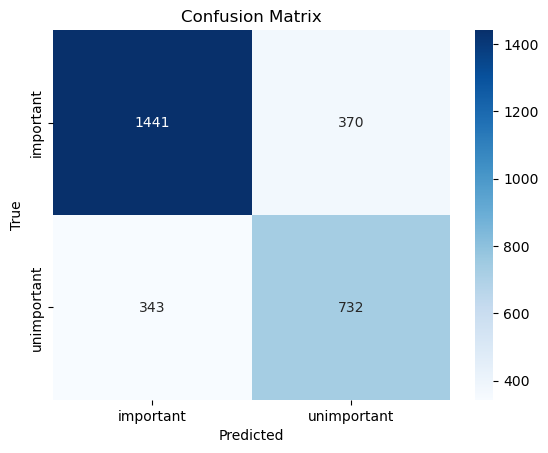

MLP - Stemming - CountVectorizer: 
 Accuracy: 0.7529452529452529 
 F1-Score: 0.7370770279499357 
 Precision: 0.7359911249827058 
 Recall: 0.738311609928987


/var/folders/sy/mt58h6rn57g5vgwg7mlmqhzh0000gn/T/ipykernel_41940/3944810572.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': 'MLP', 'data_prep': 'Stemming', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)


In [1362]:
mlp_countvec = MLPClassifier(hidden_layer_sizes=(5,3)) #hidden_layer_sizes=(100, 100, 100), max_iter=200, alpha=0.0001, solver='sgd', verbose=10, random_state=42, tol=0.000000001
mlp_countvec.fit(X_train_countvec, y_train)

y_pred_countvec = mlp_countvec.predict(X_test_countvec)

train_accuracy = mlp_countvec.score(X_train_countvec, y_train)

accuracy = accuracy_score(y_test, y_pred_countvec)
f1 = f1_score(y_test, y_pred_countvec, average='macro')
precision = precision_score(y_test, y_pred_countvec, average='macro')
recall = recall_score(y_test, y_pred_countvec, average='macro')

labels = ['important', 'unimportant']
cm = confusion_matrix(y_test, y_pred_countvec, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

results = results.append({'model': 'MLP', 'data_prep': 'Stemming', 'vectorizer': 'CountVectorizer', 'train_accuracy': train_accuracy, 'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}, ignore_index=True)
print(f"MLP - Stemming - CountVectorizer: \n Accuracy: {accuracy} \n F1-Score: {f1} \n Precision: {precision} \n Recall: {recall}")

## Results

In [1363]:
results.to_excel('results.xlsx', index=False)
results

,model,data_prep,vectorizer,accuracy,f1_score,precision,recall,train_accuracy
0,Naive Bayes,Lemmatization,TF-IDF,0.767498,0.710230,0.812153,0.699627,0.842388
1,Naive Bayes,Lemmatization,CountVectorizer,0.797990,0.771600,0.797512,0.760783,0.876700
2,Logistic Regression,Lemmatization,TF-IDF,0.801802,0.779491,0.796236,0.770814,0.886405
3,Logistic Regression,Lemmatization,CountVectorizer,0.814276,0.799962,0.802269,0.797954,0.923144
4,SVM,Lemmatization,TF-IDF,0.806306,0.787575,0.797228,0.781397,0.914392
5,SVM,Lemmatization,CountVectorizer,0.797644,0.784686,0.783329,0.786214,0.947318
6,Decision Tree,Lemmatization,TF-IDF,0.750866,0.731932,0.733458,0.730606,0.998007
7,Decision Tree,Lemmatization,CountVectorizer,0.741164,0.722791,0.723094,0.722498,0.998007
8,Random Forest,Lemmatization,TF-IDF,0.790021,0.764982,0.784281,0.755945,0.998007
9,Random Forest,Lemmatization,CountVectorizer,0.797644,0.777722,0.787820,0.771470,0.998007
